In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import ipdb

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [4]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit')]

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [7]:
FILE_NAME,ID,IMAGE_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]: o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]: o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [8]:
JPEGS = Path('VOCdevkit/VOC2007/JPEGImages')

In [9]:
IMG_PATH = PATH / 'VOCdevkit/VOC2007/JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000001.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000002.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000003.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000004.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000005.jpg')]

In [10]:
trn_anno = collections.defaultdict(lambda: [])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMAGE_ID]].append((bb, o[CAT_ID]))

len(trn_anno)

2501

In [11]:
im0_d = trn_j[IMAGES][0]
im0_d

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

In [12]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [13]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [14]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])


In [15]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [16]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [17]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [18]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 2)

In [19]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [20]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

### Large classifier

In [21]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [22]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [23]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [24]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [25]:
f_model = resnet34
sz = 224
bs = 64

In [26]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)


In [84]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [85]:
lrf = learn.lr_find(1e-05, 100)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 105/126 [00:07<00:01, 14.38it/s, loss=379]


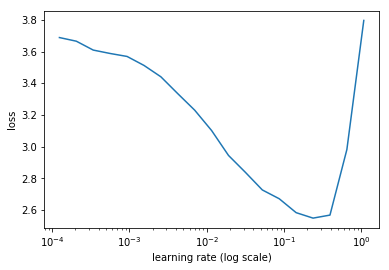

In [29]:
learn.sched.plot(5, 1)

In [30]:
lr = 2e-02

In [31]:
tqdm.monitor_interval = 0

In [32]:
learn.fit(lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.298713   0.629671   0.821514  



[0.62967086, 0.8215144202113152]

In [33]:
lrs = np.array([lr/1000, lr/100, lr])

In [34]:
learn.freeze_to(-2)

In [35]:
learn.fit(lrs, n_cycle=2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      1.127051   0.940816   0.768179  
    1      0.700551   0.643592   0.814754                  
    2      0.555157   0.902775   0.80018                   
    3      0.367182   0.711899   0.830379                  



[0.7118994, 0.8303786069154739]

In [36]:
lrf = learn.lr_find(lrs/1000)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 24/32 [00:12<00:04,  1.91it/s, loss=0.637]

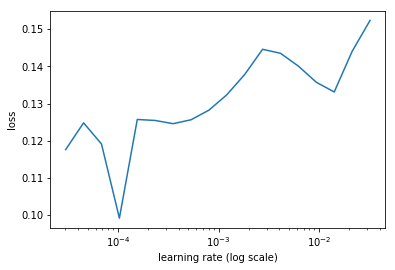

In [37]:
learn.sched.plot(1)

In [38]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 44%|████▍     | 14/32 [00:07<00:09,  1.94it/s, loss=0.151]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.132581   0.700788   0.842548  



[0.7007883, 0.8425480797886848]

In [39]:
learn.unfreeze()

In [40]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.127697   0.693714   0.840144  
    1      0.084521   0.715181   0.8436                     



[0.71518075, 0.843599759042263]

In [41]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


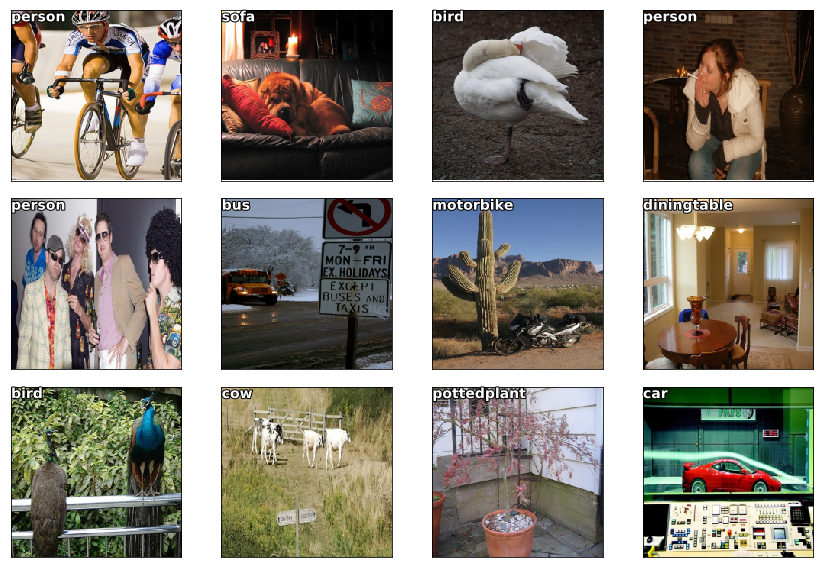

In [42]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

# BBoxes

In [43]:
BB_CSV = PATH/'tmp/bb.csv'

In [44]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [46]:
f_model=resnet34
sz=224
bs=64

In [50]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(10, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)]

In [127]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 52.  38. 105. 182.]
[ 58.  33. 117. 189.]
[ 56.  32. 120. 190.]
[ 47.  33. 118. 189.]
[ 66.  38. 104. 182.]
[ 37.  26. 129. 196.]
[ 48.  33. 116. 189.]
[ 46.  32. 114. 190.]
[ 53.  30. 125. 192.]


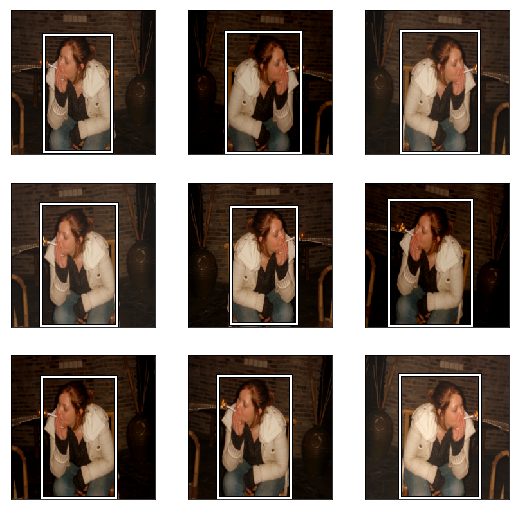

In [128]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [88]:
head_reg4 = nn.Sequential(Flatten(),
                          nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [89]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:07<00:00,  3.65it/s, loss=442] 


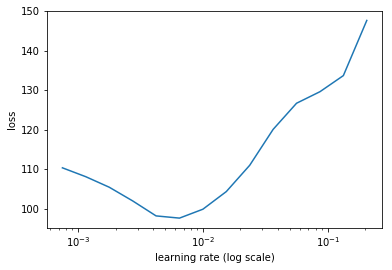

In [90]:
learn.lr_find(1e-5, 10)
learn.sched.plot()

In [61]:
lr = 1e-3

In [63]:
learn.fit(lr, 2, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      28.219221  27.633394 
    1      24.477599  26.363085                             
    2      27.216422  30.111626                             
    3      24.017572  25.574245                             
    4      22.159655  25.144279                             
    5      20.921366  24.934223                             



[24.934223]

In [64]:
lrs = np.array([lr/100, lr/10, lr])

In [65]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 472/501 [00:26<00:01, 18.05it/s, loss=111] 

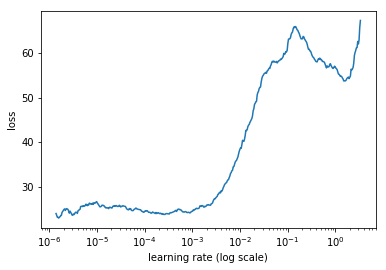

 94%|█████████▍| 472/501 [00:40<00:02, 11.79it/s, loss=111]

In [68]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [69]:
lrs = lrs/10

In [70]:
learn.fit(lrs, 2, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 33%|███▎      | 163/501 [00:09<00:19, 17.62it/s, loss=22.9]

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/mnt/fast/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      23.695686  26.928322 
    1      21.85505   26.030365                             
    2      22.216338  26.294758                             
    3      19.704486  25.656916                             
    4      19.569057  25.662386                             
    5      18.066659  25.181553                             



[25.181553]

In [71]:
learn.freeze_to(-3)

In [72]:
learn.fit(lrs*10, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      25.613863  27.389996 
    1      18.934635  23.836031                             



[23.836031]

In [73]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

IndexError: index 4 is out of bounds for axis 0 with size 4

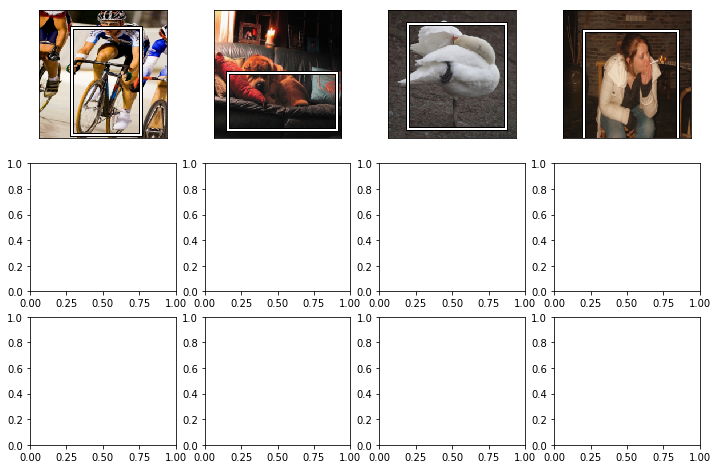

In [91]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
#     ipdb.set_trace()
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Single object detection

In [129]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [130]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [131]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [132]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [133]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [134]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [135]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 106., 184.], dtype=float32)

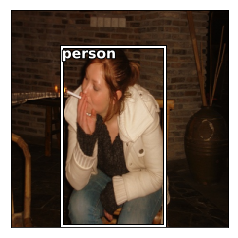

In [136]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [137]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)

In [138]:
model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

In [139]:
learn = ConvLearner(md, model)
learn.opt_fn = optim.Adam

In [140]:
def detn_loss(inp, target):
    bb_t, c_t = target
    bb_i, c_i = inp[:, :4], inp[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:07<00:00,  3.80it/s, loss=444]


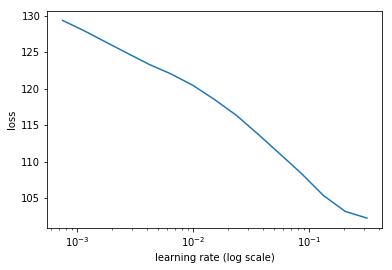

In [141]:
learn.lr_find()


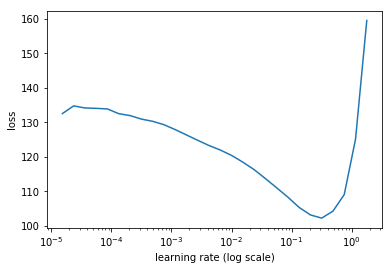

In [142]:
learn.sched.plot(1, 1)

In [143]:
lr = 2e-1

In [144]:
learn.fit(lr, 1, cycle_len=2, use_clr=(30, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      117.226219 88.703171  0.702224   47.467048 
    1      100.138986 69.744324  0.783654   46.912895    



[69.74432, 0.7836538478732109, 46.91289472579956]

In [145]:
learn.freeze_to(-2)

In [146]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s, loss=352] 

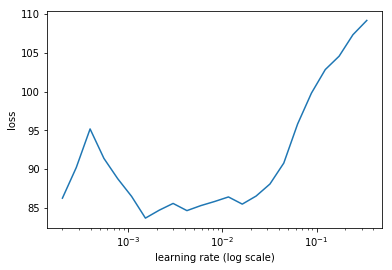

In [149]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [151]:
learn.fit(lrs/10, 1, cycle_len=8)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      80.07612   5822.225586 0.347055   44.157125 
    1      73.760052  92.222389  0.528395   30.343514     
    2      66.847975  57.176613  0.564002   28.613504     
    3      59.295685  53.348846  0.640925   29.453596     
    4      53.379996  48.074959  0.658504   24.945181     
    5      48.268613  47.013893  0.663762   24.448548     
    6      43.856195  45.53616   0.681941   24.255904     
    7      41.745632  45.025894  0.690204   23.893977     



[45.025894, 0.6902043297886848, 23.893977165222168]

In [152]:
learn.fit(lrs/10, 1, cycle_len=3, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      52.209889  56.498726  0.565805   27.6686   
    1      49.028229  50.728439  0.625901   26.198336     
    2      43.239122  47.179283  0.661959   24.797396     



[47.179283, 0.661959134042263, 24.797395944595337]

In [153]:
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:17<00:03,  1.52it/s, loss=184] 

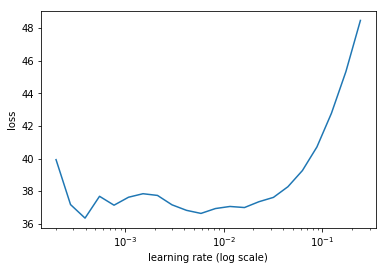

In [154]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [159]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      47.848173  6450.115723 0.470403   32.94639  
    1      48.230043  62.814365  0.514123   25.22834      
    2      44.041434  55.777397  0.613281   25.36435      
    3      40.345008  54.777931  0.6561     25.708975     
    4      36.625123  49.822647  0.632812   23.890366     



[49.822647, 0.6328125, 23.890366315841675]

In [160]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [161]:
from scipy.special import expit

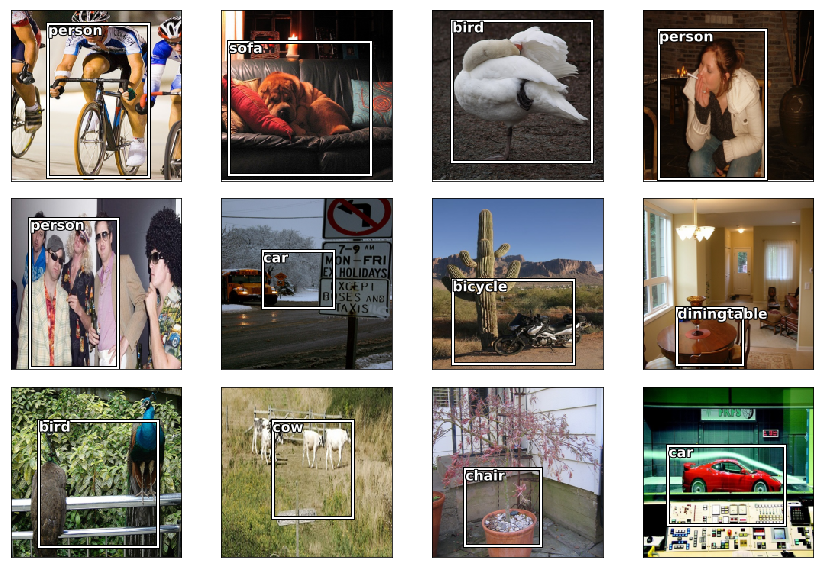

In [162]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()